<h1 align=center><font size = 5>Segmenting, Clustering and Comparing Neighborhoods from  New York City and London</font></h1>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [18]:
import os
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from time import sleep

import requests # library to handle requests
import json # librart to handle json files

# Matplotlib and associated plotting modules

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import matplotlib.cm as cm
import matplotlib.colors as colors


# import k-means from clustering stage
from sklearn.cluster import KMeans

# import to encode categorized features
from sklearn import preprocessing

import folium # map rendering library

from unidecode import unidecode

from lxml import html

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

#### Load and explore the data

In [19]:
try:
    nyc_data = requests.get("https://cocl.us/new_york_dataset").json()
except Exception:
    with open('newyork_data.json', 'r') as json_data:
        nyc_data = json.load(json_data)
print('Data downloaded!')

Data downloaded!


All the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [20]:
neighborhoods_data = nyc_data['features']

Let's take a look at the first item in this list.

In [21]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Transform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [22]:
# define the dataframe columns
column_names = ['borough', 'neighborhood', 'latitude', 'longitude'] 

# instantiate the dataframe
nyc_data = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [23]:
nyc_data

,borough,neighborhood,latitude,longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [24]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_data = nyc_data.append({'borough': borough,
                                'neighborhood': neighborhood_name,
                                'latitude': neighborhood_lat,
                                'longitude': neighborhood_lon
                                },
                               ignore_index=True
                               )

Quickly examine the resulting dataframe.

In [100]:
print(f"There are {nyc_data.shape[0]} neighborhoods in NYC grouped in 5 boroughs")
nyc_data['borough'].value_counts()

There are 306 neighborhoods in NYC grouped in 5 boroughs


Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: borough, dtype: int64

In [25]:
print(nyc_data.shape)
nyc_data.head()

(306, 4)


,borough,neighborhood,latitude,longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [26]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nyc_data['borough'].unique()),
        nyc_data.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Let's encode NYC's boroughs

In [27]:
region_encoder = preprocessing.LabelEncoder()
region_encoder.fit(nyc_data['borough'])
nyc_data.insert(1, 'borough_encoded', region_encoder.transform(nyc_data['borough']))
nyc_data.head()

,borough,borough_encoded,neighborhood,latitude,longitude
0,Bronx,0,Wakefield,40.894705,-73.847201
1,Bronx,0,Co-op City,40.874294,-73.829939
2,Bronx,0,Eastchester,40.887556,-73.827806
3,Bronx,0,Fieldston,40.895437,-73.905643
4,Bronx,0,Riverdale,40.890834,-73.912585


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [28]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geographical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [29]:
# create map of New York using latitude and longitude values
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=10)

num_borough = nyc_data['borough_encoded'].unique()
color_range = list(range(0, len(num_borough)))
colors_array = [cm.tab10(x + 1) for x in color_range]
cat_colors = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, borough, neighborhood, borough_encoded in zip(nyc_data['latitude'], nyc_data['longitude'], nyc_data['borough'], nyc_data['neighborhood'], nyc_data['borough_encoded']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=cat_colors[borough_encoded],
        fill=True,
        fill_color=cat_colors[borough_encoded],
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)
    
map_nyc

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, in this project we will segment and cluster only the neighborhoods in Manhattan so we can compare to Central London since the neighborhoods in those areas are the most well known to everybody. 

So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [101]:
nyc_data = nyc_data.loc[nyc_data['borough'] == 'Manhattan'].reset_index(drop=True)

print(nyc_data.shape)
nyc_data.head()

(40, 5)


,borough,borough_encoded,neighborhood,latitude,longitude
0,Manhattan,2,Marble Hill,40.876551,-73.910660
1,Manhattan,2,Chinatown,40.715618,-73.994279
2,Manhattan,2,Washington Heights,40.851903,-73.936900
3,Manhattan,2,Inwood,40.867684,-73.921210
4,Manhattan,2,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [233]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


As we did with all of New York City, let's visualizat Manhattan the neighborhoods in it.

In [234]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(nyc_data['latitude'], nyc_data['longitude'], nyc_data['neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

## 2. Explore Neighborhoods in Manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [235]:
%load_ext dotenv
# Use find_dotenv to locate the file
%dotenv passwords.env

CLIENT_ID = os.getenv('CLIENT_ID') # your Foursquare ID
CLIENT_SECRET = os.getenv('CLIENT_SECRET') # your Foursquare Secret
VERSION = os.getenv('VERSION') # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + ('LOADED' if CLIENT_ID is not None else 'NOT LOADED'))
print('CLIENT_SECRET:' + ('LOADED' if CLIENT_SECRET is not None else 'NOT LOADED'))

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Your credentails:
CLIENT_ID: LOADED
CLIENT_SECRET:LOADED


#### Let's create a function to repeat the same process to all the neighborhoods

In [236]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        sleep(1)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'neighborhood', 
        'neighborhood_latitude', 
        'neighborhood_longitude', 
        'venue', 
        'venue_latitude', 
        'venue_longitude', 
        'venue_category'
        ]
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *nyc_venues*.

In [237]:
# type your answer here
nyc_venues = getNearbyVenues(names=nyc_data['neighborhood'],
                             latitudes=nyc_data['latitude'],
                             longitudes=nyc_data['longitude']
                             )
nyc_venues.head()

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


#### Let's check the size of the resulting dataframe

In [238]:
print(nyc_venues.shape)
nyc_venues.head()

(3218, 7)


,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


Let's check how many venues were returned for each neighborhood

In [239]:
nyc_venues.groupby('neighborhood').count().head()

,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
neighborhood,,,,,,
Battery Park City,66,66,66,66,66,66
Carnegie Hill,90,90,90,90,90,90
Central Harlem,45,45,45,45,45,45
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [240]:
print('There are {} uniques categories.'.format(len(nyc_venues['venue_category'].unique())))

There are 323 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [241]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['venue_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['neighborhood'] = nyc_venues['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

print(nyc_onehot.shape)
nyc_onehot.head()

(3218, 324)


,neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Re

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [242]:
nyc_grouped = nyc_onehot.groupby('neighborhood').mean().reset_index()
print(nyc_grouped.shape)
nyc_grouped.head()

(40, 324)


,neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Re

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [243]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [244]:
def top_venues_neighboorhood(num_venues, city_grouped):
    num_top_venues = num_venues

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['neighborhood'] = city_grouped['neighborhood']

    for ind in np.arange(city_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)
    
    return neighborhoods_venues_sorted

In [245]:
neighborhoods_venues_sorted = top_venues_neighboorhood(10, nyc_grouped)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(40, 11)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Shopping Mall,Plaza,Burger Joint,Gourmet Shop,Playground
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Pizza Place,Wine Shop,Italian Restaurant,Gym / Fitness Center,Gym,Bookstore,French Restaurant
2,Central Harlem,African Restaurant,Chinese Restaurant,French Restaurant,American Restaurant,Bar,Seafood Restaurant,Cosmetics Shop,Grocery Store,Library,Tapas Restaurant
3,Chelsea,Coffee Shop,Art Gallery,Bakery,American Restaurant,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Park,Cycle Studio,Cupcake Shop
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Hotpot Restaurant,Dessert Shop,Spa,Optical Shop,Salon / Barbershop,Noodle House


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run the elbow method to get optimal K

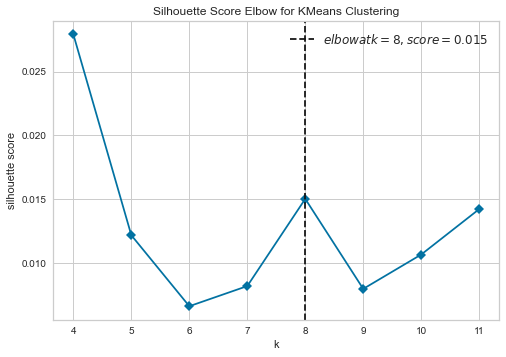

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [246]:
from yellowbrick.cluster import KElbowVisualizer

nyc_grouped_clustering = nyc_grouped.drop('neighborhood', 1)

# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(4,12), metric='silhouette', timings=False, locate_elbow=True)

visualizer.fit(nyc_grouped_clustering)# Fit the data to the visualizer
visualizer.poof() # Finalize and render the figure

Run *k*-means to cluster the neighborhood into 5 clusters because there are 5 boroughs in NYC.

In [247]:
# set number of clusters
kclusters = visualizer.elbow_value_

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 5, 2, 5, 2, 2, 2, 1, 5, 5], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [248]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'cluster_labels', kmeans.labels_)

nyc_merged = nyc_data.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood')

print(nyc_merged.shape)
nyc_merged.head() # check the last columns!

(40, 16)


,borough,borough_encoded,neighborhood,latitude,longitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,2,Marble Hill,40.876551,-73.910660,3,Sandwich Place,Coffee Shop,Gym,Discount Store,Supplement Shop,Donut Shop,Seafood Restaurant,Tennis Stadium,Kids Store,Pharmacy
1,Manhattan,2,Chinatown,40.715618,-73.994279,2,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Hotpot Restaurant,Dessert Shop,Spa,Optical Shop,Salon / Barbershop,Noodle House
2,Manhattan,2,Washington Heights,40.851903,-73.936900,1,Café,Bakery,Grocery Store,Mobile Phone Shop,Spanish Restaurant,Supermarket,Coffee Shop,Park,Bank,Deli / Bodega
3,Manhattan,2,Inwood,40.867684,-73.921210,1,Mexican Restaurant,Café,Lounge,Restaurant,Park,Chinese Restaurant,Bakery,Frozen Yogurt Shop,Caribbean Restaurant,American Restaurant
4,Manhattan,2,Hamilton Heights,40.823604,-73.949688,1,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Cocktail Bar,Indian Restaurant,Liquor Store,Sushi Restaurant,Park,Deli / Bodega


Finally, let's visualize the resulting clusters

In [249]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
color_range = list(range(0, kclusters))
colors_array = [cm.tab10(x) for x in color_range]
cat_colors = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['latitude'], nyc_merged['longitude'], nyc_merged['neighborhood'], nyc_merged['cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cat_colors[cluster],
        fill=True,
        fill_color=cat_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [250]:
nyc_cluster1 = nyc_merged.loc[nyc_merged['cluster_labels'] == 0, nyc_merged.columns[[2] + list(range(6, nyc_merged.shape[1]))]]

print(nyc_cluster1.shape)
nyc_cluster1.head()

(1, 11)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Manhattanville,Seafood Restaurant,Coffee Shop,Mexican Restaurant,Deli / Bodega,Italian Restaurant,Spanish Restaurant,Liquor Store,Lounge,Boutique,Sushi Restaurant


#### Cluster 2

In [251]:
nyc_cluster2 = nyc_merged.loc[nyc_merged['cluster_labels'] == 1, nyc_merged.columns[[2] + list(range(6, nyc_merged.shape[1]))]]

print(nyc_cluster2.shape)
nyc_cluster1.head()

(7, 11)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Manhattanville,Seafood Restaurant,Coffee Shop,Mexican Restaurant,Deli / Bodega,Italian Restaurant,Spanish Restaurant,Liquor Store,Lounge,Boutique,Sushi Restaurant


#### Cluster 3

In [252]:
nyc_cluster3 = nyc_merged.loc[nyc_merged['cluster_labels'] == 2, nyc_merged.columns[[2] + list(range(6, nyc_merged.shape[1]))]]


print(nyc_cluster3.shape)
nyc_cluster3.head()

(12, 11)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Hotpot Restaurant,Dessert Shop,Spa,Optical Shop,Salon / Barbershop,Noodle House
6,Central Harlem,African Restaurant,Chinese Restaurant,French Restaurant,American Restaurant,Bar,Seafood Restaurant,Cosmetics Shop,Grocery Store,Library,Tapas Restaurant
8,Upper East Side,Italian Restaurant,Exhibit,Coffee Shop,Bakery,Gym / Fitness Center,Spa,French Restaurant,Juice Bar,Yoga Studio,Cosmetics Shop
13,Lincoln Square,Plaza,Café,Italian Restaurant,Concert Hall,Performing Arts Venue,Theater,French Restaurant,Indie Movie Theater,Wine Shop,American Restaurant
14,Clinton,Theater,Gym / Fitness Center,American Restaurant,Italian Restaurant,Sandwich Place,Gym,Coffee Shop,Cocktail Bar,Spa,Wine Shop


#### Cluster 4

In [253]:
nyc_cluster4 = nyc_merged.loc[nyc_merged['cluster_labels'] == 3, nyc_merged.columns[[2] + list(range(6, nyc_merged.shape[1]))]]

print(nyc_cluster4.shape)
nyc_cluster4.head()

(1, 11)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Sandwich Place,Coffee Shop,Gym,Discount Store,Supplement Shop,Donut Shop,Seafood Restaurant,Tennis Stadium,Kids Store,Pharmacy


#### Cluster 5

In [254]:
nyc_cluster5 = nyc_merged.loc[nyc_merged['cluster_labels'] == 4, nyc_merged.columns[[2] + list(range(6, nyc_merged.shape[1]))]]

print(nyc_cluster5.shape)
nyc_cluster5.head()

(1, 11)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Park,Pet Service,Cocktail Bar,Harbor / Marina,Gym / Fitness Center,Baseball Field,Bar,Bistro,Heliport,Farmers Market


#### Cluster 6

In [255]:
nyc_cluster6 = nyc_merged.loc[nyc_merged['cluster_labels'] == 5, nyc_merged.columns[[2] + list(range(6, nyc_merged.shape[1]))]]

print(nyc_cluster6.shape)
nyc_cluster6.head()

(16, 11)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Yorkville,Italian Restaurant,Gym,Bar,Coffee Shop,Deli / Bodega,Sushi Restaurant,Japanese Restaurant,Wine Shop,Mexican Restaurant,Diner
10,Lenox Hill,Coffee Shop,Italian Restaurant,Sushi Restaurant,Pizza Place,Café,Cocktail Bar,Gym,Burger Joint,Gym / Fitness Center,Cycle Studio
12,Upper West Side,Italian Restaurant,Bar,Café,Indian Restaurant,Coffee Shop,Wine Bar,Pizza Place,Bakery,Ice Cream Shop,Mediterranean Restaurant
17,Chelsea,Coffee Shop,Art Gallery,Bakery,American Restaurant,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Park,Cycle Studio,Cupcake Shop
18,Greenwich Village,Italian Restaurant,Café,Clothing Store,Sushi Restaurant,Indian Restaurant,Gym,Boutique,Burger Joint,Seafood Restaurant,Pilates Studio


#### Cluster 7

In [136]:
nyc_cluster7 = nyc_merged.loc[nyc_merged['cluster_labels'] == 6, nyc_merged.columns[[2] + list(range(6, nyc_merged.shape[1]))]]

print(nyc_cluster7.shape)
nyc_cluster7.head()

(1, 11)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Midtown South,Korean Restaurant,Hotel,Japanese Restaurant,Cosmetics Shop,Burger Joint,Café,Coffee Shop,Dessert Shop,Gym / Fitness Center,Bakery


#### Cluster 8

In [256]:
nyc_cluster8 = nyc_merged.loc[nyc_merged['cluster_labels'] == 7, nyc_merged.columns[[2] + list(range(6, nyc_merged.shape[1]))]]

print(nyc_cluster8.shape)
nyc_cluster8.head()

(1, 11)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Roosevelt Island,Deli / Bodega,Japanese Restaurant,School,Greek Restaurant,Supermarket,Bubble Tea Shop,Pizza Place,Food & Drink Shop,Soccer Field,Farmers Market


# London

London is composed of 32 boroughs plus the City of London that are grouped in 5 sub-regions. Each borough is composed of a few "areas" which are equivalent to the neighborhoods in New York City. So in order to create a similar dataset I will collect data from two wikipedia pages and combine the results.

In [281]:
url_areas = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
url_regions = 'https://en.wikipedia.org/wiki/List_of_sub-regions_used_in_the_London_Plan'

session = requests.session()
session.verify = False

resp_areas = session.get(url_areas)
resp_regions = session.get(url_regions)

root_areas = html.fromstring(resp_areas.content)
root_regions = html.fromstring(resp_regions.content)

In [282]:
# Function to extract data from wikipedia tables
def extract_data(root):
    row_combox = root.xpath('.//table[contains(@class, "wikitable")]')
    row_combox = row_combox[0].xpath('.//tbody/tr')
    cols = [unidecode(line.text.strip()).replace(" ", "_").lower() if line.text is not None else None for line in list(row_combox[0])]

    data = []
    for row in row_combox[1:]:
        row_dict = {}
        for col in zip(cols, list(row)):
            row_dict[col[0]] = col[1].text_content().split('[')[0].strip()
        
        data.append(row_dict)
    
    return data

In [283]:
london_areas = extract_data(root_areas)
london_areas = pd.DataFrame(london_areas)

print(london_areas.shape)
london_areas.head()

(533, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


### Data Wrangling 

First, I will modify the london_areas data so there is only one borough per location. The reason for that, is because in order to assign a region to a location, I need to know its borough. Let's use the geopy library to search the location and use the borough it returns. 

Remove parentheses from location  

In [284]:
def remove_parentheses(row):
    location = row['location']
    if '(' in location:
        location = location.split('(')[0].strip()
    return location

In [285]:
london_areas['location'] = london_areas.apply(remove_parentheses, axis=1)

print(london_areas.shape)
london_areas.head()

(533, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


Select locations with more than one borough

In [286]:
borough_comma = london_areas.loc[london_areas['london_borough'].str.contains(', | &')]

print(borough_comma.shape)
borough_comma.head()

(27, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
85,Chadwell Heath,"Redbridge, Barking and Dagenham",ROMFORD,RM6,020,TQ485885
99,Chiswick,"Hounslow, Ealing, Hammersmith and Fulham",LONDON,W4,020,TQ205785
102,Clapham,"Lambeth, Wandsworth",LONDON,SW4,020,TQ295755


In [287]:
def select_neighborhood(row):
    area = row['location']
    borough = row['london_borough']
    nomi = Nominatim(user_agent='london_app')
    result = nomi.geocode(f'{area}, London, United Kingdom')
    
    for line in result[0].split(','):
        if 'Borough of' in line:
            borough = line.split('of')[-1].strip()
            break
        
    return borough

In [288]:
borough_comma.loc[:, 'london_borough'] = borough_comma.apply(select_neighborhood, axis=1)
borough_comma.loc[borough_comma['london_borough'].str.contains(', | &')]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
457,Temple,"City, Westminster",LONDON,"EC4, WC2",020,TQ311809


As we can see there are still some locations where it wasn't possible to update the neighborhood using geopy so those I will research online and fix by hand.  

In [289]:
indexes = borough_comma.loc[borough_comma['london_borough'].str.contains(', | &')].index
new_boroughs = ['City']
borough_comma.loc[indexes, 'london_borough'] = new_boroughs

print(borough_comma.shape)
borough_comma

(27, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,Greenwich,LONDON,SE2,020,TQ465785
1,Acton,Ealing,LONDON,"W3, W4",020,TQ205805
85,Chadwell Heath,Redbridge,ROMFORD,RM6,020,TQ485885
99,Chiswick,Hounslow,LONDON,W4,020,TQ205785
102,Clapham,Wandsworth,LONDON,SW4,020,TQ295755
104,Cockfosters,Enfield,BARNET,EN4,020,TQ275965
121,Cricklewood,Brent,LONDON,NW2,020,TQ235855
168,Falconwood,Bexley,"LONDON, WELLING","SE9, DA16",020,TQ455755
169,Farringdon,Islington,LONDON,EC1,020,TQ315818
173,Finsbury Park,Islington,LONDON,N4,020,TQ314872


In [290]:
london_areas.loc[borough_comma.index, 'london_borough'] = borough_comma['london_borough']

print(london_areas.iloc[borough_comma.index].shape)
london_areas.iloc[borough_comma.index].head()

(27, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,Greenwich,LONDON,SE2,020,TQ465785
1,Acton,Ealing,LONDON,"W3, W4",020,TQ205805
85,Chadwell Heath,Redbridge,ROMFORD,RM6,020,TQ485885
99,Chiswick,Hounslow,LONDON,W4,020,TQ205785
102,Clapham,Wandsworth,LONDON,SW4,020,TQ295755


Convert OS Grid (British National Grid References) to Latitude & Longitude

In [291]:
from OSGridConverter import grid2latlong

def grid_conversion(row):
    grid = row['os_grid_ref'].strip()
    latitude = None
    longitude = None
    if len(grid):
        coord = grid2latlong(grid)
        latitude = coord.latitude
        longitude = coord.longitude
    
    else:
        nomi = Nominatim(user_agent='london_app')
        location = row['location']
        borough = row['london_borough']
        result = nomi.geocode(f'{location}, {borough}, London, United Kingdom')

        if result is not None:
            latitude = result[1][0]
            longitude = result[1][1]

    return latitude, longitude

In [292]:
london_areas[['latitude', 'longitude']] = ''
london_areas[['latitude', 'longitude']] = london_areas.apply(grid_conversion, axis=1, result_type='expand')

print(london_areas.shape)
london_areas.head()

(533, 8)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
0,Abbey Wood,Greenwich,LONDON,SE2,020,TQ465785,51.486484,0.109318
1,Acton,Ealing,LONDON,"W3, W4",020,TQ205805,51.510591,-0.264585
2,Addington,Croydon,CROYDON,CR0,020,TQ375645,51.362934,-0.025780
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665,51.381625,-0.068126
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,51.434929,0.125663


Rename borough "City" to "City of London"

In [293]:
london_areas['london_borough'] = london_areas['london_borough'].str.replace('City', 'City of London')
london_areas.head(10)

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
0,Abbey Wood,Greenwich,LONDON,SE2,020,TQ465785,51.486484,0.109318
1,Acton,Ealing,LONDON,"W3, W4",020,TQ205805,51.510591,-0.264585
2,Addington,Croydon,CROYDON,CR0,020,TQ375645,51.362934,-0.025780
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665,51.381625,-0.068126
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,51.434929,0.125663
5,Aldborough Hatch,Redbridge,ILFORD,IG2,020,TQ455895,51.585581,0.099459
6,Aldgate,City of London,LONDON,EC3,020,TQ334813,51.514885,-0.078356
7,Aldwych,Westminster,LONDON,WC2,020,TQ307810,51.512819,-0.117388
8,Alperton,Brent,WEMBLEY,HA0,020,TQ185835,51.537976,-0.292401
9,Anerley,Bromley,LONDON,SE20,020,TQ345695,51.408585,-0.066989


Fix problematic locations

In [294]:
london_areas.loc[(london_areas['location'] == 'Brompton') | (london_areas['location'] == 'Sudbury') | (london_areas['location'] == 'Somerstown')]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
68,Brompton,Kensington and ChelseaHammersmith and Fulham,LONDON,SW3,020,TQ275795,51.500069,-0.164056
411,Somerstown,Camden,LONDON,NW1,020,TQ295825,51.526575,-0.134133
448,Sudbury,Newham,"HARROW, WEMBLEY","HA0, HA1",020,TQ165852,51.553670,-0.320682


In [295]:
london_areas.loc[68, 'london_borough'] = 'Kensington and Chelsea'
london_areas.loc[411, 'location'] = 'Somers Town'
london_areas.loc[448, 'london_borough'] = 'Brent'
london_areas.iloc[[68, 411, 448]]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
68,Brompton,Kensington and Chelsea,LONDON,SW3,020,TQ275795,51.500069,-0.164056
411,Somers Town,Camden,LONDON,NW1,020,TQ295825,51.526575,-0.134133
448,Sudbury,Brent,"HARROW, WEMBLEY","HA0, HA1",020,TQ165852,51.553670,-0.320682


Now that we fixed the dataset, let's check if we got 33 unique boroughs, which is London's official number of boroughs.

In [296]:
len(london_areas['london_borough'].unique())

36

We have 3 more boroughs than we should have. In order to find out which ones are wrong, I will download an oficial government dataset containing information about London's boroughs and will compare it with our list.

In [297]:
official_boroughs = pd.read_csv('https://data.london.gov.uk/download/london-borough-profiles/c1693b82-68b1-44ee-beb2-3decf17dc1f8/london-borough-profiles.csv', engine='python', encoding='latin1')
official_boroughs.head()

,Code,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,Inland_Area_(Hectares),Population_density_(per_hectare)_2017,"Average_Age,_2017","Proportion_of_population_aged_0-15,_2015","Proportion_of_population_of_working-age,_2015","Proportion_of_population_aged_65_and_over,_2015",Net_internal_migration_(2015),Net_international_migration_(2015),Net_natural_change_(2015),%_of_resident_population_born_abroad_(2015),Largest_migrant_population_by_country_of_birth_(2011),%_of_largest_migrant_population_(2011),Second_largest_migrant_population_by_country_of_birth_(2011),%_of_second_largest_migrant_population_(2011),Third_largest_migrant_population_by_country_of_birth_(2011),%_of_third_largest_migrant_population_(2011),%_of_population_from_BAME_groups_(2016),%_people_aged_3+_whose_main_language_is_not_English_(2011_Census),"Overseas_nationals_entering_the_UK_(NINo),_(2015/16)","New_migrant_(NINo)_rates,_(2015/16)",Largest_migrant_population_arrived_during_2015/16,Second_largest_migrant_population_arrived_during_2015/16,Third_largest_migrant_population_arrived_during_2015/16,Employment_rate_(%)_(2015),Male_employment_rate_(2015),Female_employment_rate_(2015),Unemployment_rate_(2015),Youth_Unemployment_(claimant)_rate_18-24_(Dec-15),Proportion_of_16-18_year_olds_who_are_NEET_(%)_(2014),Proportion_of_the_working-age_population_who_claim_out-of-work_benefits_(%)_(May-2016),%_working-age_with_a_disability_(2015),Proportion_of_working_age_people_with_no_qualifications_(%)_2015,Proportion_of_working_age_with_degree_or_equivalent_and_above_(%)_2015,"Gross_Annual_Pay,_(2016)",Gross_Annual_Pay_-_Male_(2016),Gross_Annual_Pay_-_Female_(2016),Modelled_Household_median_income_estimates_2012/13,%_adults_that_volunteered_in_past_12_months_(2010/11_to_2012/13),Number_of_jobs_by_workplace_(2014),%_of_employment_that_is_in_public_sector_(2014),"Jobs_Density,_2015","Number_of_active_businesses,_2015",Two-year_business_survival_rates_(started_in_2013),Crime_rates_per_thousand_population_2014/15,Fires_per_thousand_population_(2014),Ambulance_incidents_per_hundred_population_(2014),"Median_House_Price,_2015","Average_Band_D_Council_Tax_charge_(£),_2015/16",New_Homes_(net)_2015/16_(provisional),"Homes_Owned_outright,_(2014)_%","Being_bought_with_mortgage_or_loan,_(2014)_%","Rented_from_Local_Authority_or_Housing_Association,_(2014)_%","Rented_from_Private_landlord,_(2014)_%","%_of_area_that_is_Greenspace,_2005",Total_carbon_emissions_(2014),"Household_Waste_Recycling_Rate,_2014/15","Number_of_cars,_(2011_Census)","Number_of_cars_per_household,_(2011_Census)","%_of_adults_who_cycle_at_least_once_per_month,_2014/15","Average_Public_Transport_Accessibility_score,_2014","Achievement_of_5_or_more_A*-_C_grades_at_GCSE_or_equivalent_including_English_and_Maths,_2013/14",Rates_of_Children_Looked_After_(2016),%_of_pupils_whose_first_language_is_not_English_(2015),%_children_living_in_out-of-work_households_(2015),"Male_life_expectancy,_(2012-14)","Female_life_expectancy,_(2012-14)",Teenage_conception_rate_(2014),Life_satisfaction_score_2011-14_(out_of_10),Worthwhileness_score_2011-14_(out_of_10),Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
0,E09000001,City of London,Inner London,8800,5326,290,30.3,43.2,11.4,73.1,15.5,-7,665,30,.,United States,2.8,France,2,Australia,1.9,27.5,17.1,975,152.2,India,France,United States,64.6,.,.,.,1.6,.,3.4,.,.,.,.,.,.,"£63,620",.,500400,3.4,84.3,26130,64.3,.,12.3,.,799999,931.2,80,.,.,.,.,4.8,1036,34.4,1692,0.4,16.9,7.9,78.6,101,.,7.9,.,.,.,6.6,7.1,6.0,5.6,NaN,2.6,129,.,.,.,.,.
1,E09000002,Barking and Dagenham,Outer London,209000,

In [298]:
official_boroughs.dropna(inplace=True)
official_areas = official_boroughs['Area_name']
official_areas.head()

1    Barking and Dagenham
2                  Barnet
3                  Bexley
4                   Brent
5                 Bromley
Name: Area_name, dtype: object

In [299]:
# Extra boroughs
myareas = pd.Series(london_areas['london_borough'].unique())

myareas.loc[~myareas.isin(official_areas)]

5           City of London
32                Dartford
34    Camden and Islington
35     Haringey and Barnet
dtype: object

Fix problematic boroughs

In [300]:
london_areas.loc[(london_areas['london_borough'] == 'Dartford')]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
133,Dartford,Dartford,LONDON,DA5,020,TQ287861,51.55911,-0.144352


In [301]:
london_areas.loc[133, 'london_borough'] = 'Bexley'
london_areas['london_borough'] = london_areas['london_borough'].str.replace('Camden and Islington', 'Camden')
london_areas['london_borough'] = london_areas['london_borough'].str.replace('Haringey and Barnet', 'Haringey')


print(f"There are {len(london_areas['london_borough'].unique())} London neighborhoods")

There are 33 London neighborhoods


In [302]:
# Rename columns
london_areas.rename(columns={'location': 'neighborhood', 'london_borough': 'borough'}, inplace=True)

Now let's collect the assign the locations to its respective regions 

In [303]:
london_regions = extract_data(root_regions)
london_regions = pd.DataFrame(london_regions)

print(london_regions.shape)
london_regions.head()

(5, 3)


,sub-region,london_boroughs,area
0,Central,"Camden, City of London, Kensington and Chelsea...","13,136.02 hectares (50.7185 sq mi)"
1,East,"Barking and Dagenham, Bexley, Greenwich, Hackn...","47,673.77 hectares (184.0695 sq mi)"
2,North,"Barnet, Enfield, Haringey","19,853.67 hectares (76.6554 sq mi)"
3,South,"Bromley, Croydon, Kingston upon Thames, Merton...","44,936.52 hectares (173.5009 sq mi)"
4,West,"Brent, Ealing, Hammersmith and Fulham, Harrow,...","33,868.62 hectares (130.7675 sq mi)"


Spread the dataset

In [304]:
london_regions = pd.DataFrame(london_regions['london_boroughs'].str.split(',').tolist(), index=london_regions['sub-region']).stack()
london_regions = london_regions.reset_index()[['sub-region', 0]]

london_regions = london_regions.apply(lambda x: x.str.strip())

london_regions.rename(columns={'sub-region': 'sub_region', 0: 'borough'}, inplace=True)

print(london_regions.shape)
london_regions.head()

(33, 2)


,sub_region,borough
0,Central,Camden
1,Central,City of London
2,Central,Kensington and Chelsea
3,Central,Islington
4,Central,Lambeth


Now, let's merge the tables

In [305]:
london_data = pd.merge(london_regions, london_areas[['borough', 'neighborhood', 'latitude', 'longitude']], on='borough', how='inner').reset_index(drop=True)

print(london_data.shape)
london_data.head()

(533, 5)


,sub_region,borough,neighborhood,latitude,longitude
0,Central,Camden,Belsize Park,51.545049,-0.165131
1,Central,Camden,Bloomsbury,51.526345,-0.119715
2,Central,Camden,Camden Town,51.544548,-0.133398
3,Central,Camden,Chalk Farm,51.543969,-0.153628
4,Central,Camden,Fitzrovia,51.518533,-0.137347


In [306]:
# Check for nulls 
london_data.isnull().sum()

sub_region      0
borough         0
neighborhood    0
latitude        0
longitude       0
dtype: int64

In [307]:
num_neighborhoods = london_data.shape[0]
num_boroughs = len(london_data['borough'].unique())
print(f'There are {num_boroughs} boroughs and {num_neighborhoods} neighborhoods in London.')

There are 33 boroughs and 533 neighborhoods in London.


Now that the dataset is clean, let's check for duplicates in the coordinates. The reason this wasn't done before is because I wanted to fix the inconsistencies beforehand so I have the correct data to search for the correct coordinates in case I have to fix something.

In [308]:
duplicated_coord = london_data.loc[london_data.duplicated(subset=['latitude', 'longitude'], keep=False)]
print(duplicated_coord.shape)
duplicated_coord.head()

(103, 5)


,sub_region,borough,neighborhood,latitude,longitude
1,Central,Camden,Bloomsbury,51.526345,-0.119715
8,Central,Camden,Highgate,51.571737,-0.146726
9,Central,Camden,Holborn,51.517359,-0.120085
11,Central,Camden,King's Cross,51.535100,-0.104923
14,Central,Camden,St Giles,51.517359,-0.120085


In [309]:
print(f"There are {duplicated_coord.shape[0]} neighborhoods that have potentially bad coordinates so I will use geopy to search for all of them")

There are 103 neighborhoods that have potentially bad coordinates so I will use geopy to search for all of them


In [310]:
nomi = Nominatim(user_agent='london')
nomi.geocode(f'Bloomsbury, Camden, London, United Kingdom')[1]

(51.523126, -0.1260664)

In [311]:
# Get coordinates 
def get_coordinates(row):
    neighborhood = row['neighborhood'] 
    borough = row['borough']
    nomi = Nominatim(user_agent='london')
    result = nomi.geocode(f'{neighborhood}, {borough}, London, United Kingdom')
    
    latitude = None
    longitude = None
    
    if result is not None:
        latitude = result[1][0]
        longitude = result[1][1]
        
    return latitude, longitude

In [312]:
duplicated_coord[['latitude', 'longitude']] = duplicated_coord.apply(get_coordinates, axis=1, result_type='expand')

print(duplicated_coord.shape)
duplicated_coord.head()

(103, 5)


,sub_region,borough,neighborhood,latitude,longitude
1,Central,Camden,Bloomsbury,51.523126,-0.126066
8,Central,Camden,Highgate,51.577683,-0.145832
9,Central,Camden,Holborn,51.517934,-0.119528
11,Central,Camden,King's Cross,51.532395,-0.123022
14,Central,Camden,St Giles,51.515472,-0.128418


Look for, and fix nulls values in the new coordinates

In [313]:
duplicated_coord.loc[duplicated_coord.isnull().any(1)]

,sub_region,borough,neighborhood,latitude,longitude
121,East,Bexley,North End,NaN,NaN
255,East,Waltham Forest,Cann Hall,NaN,NaN
375,South,Croydon,Old Coulsdon,NaN,NaN
398,South,Kingston upon Thames,Old Malden,NaN,NaN


After checking on Google, the original coordinates for those two neighborhoods were correct so I will keep them in the dataset and update the new ones.

In [314]:
index2update = np.setdiff1d(duplicated_coord.index, duplicated_coord.loc[duplicated_coord.isnull().any(1)].index)
london_data.loc[index2update, ['latitude', 'longitude']] = duplicated_coord.loc[index2update, ['latitude', 'longitude']]

print(f"There are {london_data.duplicated(subset=['latitude', 'longitude'], keep=False).sum()} duplicate coordinates left.")

There are 0 duplicate coordinates left.


#### Change the coordinates columns data type

In [315]:
london_data['latitude'] = london_data['latitude'].astype('float64')
london_data['longitude'] = london_data['longitude'].astype('float64')
london_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sub_region    533 non-null    object 
 1   borough       533 non-null    object 
 2   neighborhood  533 non-null    object 
 3   latitude      533 non-null    float64
 4   longitude     533 non-null    float64
dtypes: float64(2), object(3)
memory usage: 20.9+ KB


Use geopy library to get the latitude and longitude values of London.

In [316]:
address = 'London, England'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of London are {}, {}.'.format(latitude, longitude))

The geographical coordinate of London are 51.5073219, -0.1276474.


Encode "sub_region" column

In [317]:
from sklearn import preprocessing

region_encoder = preprocessing.LabelEncoder()
region_encoder.fit(london_data['sub_region'])
region_encoder.classes_

array(['Central', 'East', 'North', 'South', 'West'], dtype=object)

In [318]:
london_data.insert(1, 'sub_region_encoded', region_encoder.transform(london_data['sub_region']))
london_data.head()

,sub_region,sub_region_encoded,borough,neighborhood,latitude,longitude
0,Central,0,Camden,Belsize Park,51.545049,-0.165131
1,Central,0,Camden,Bloomsbury,51.523126,-0.126066
2,Central,0,Camden,Camden Town,51.544548,-0.133398
3,Central,0,Camden,Chalk Farm,51.543969,-0.153628
4,Central,0,Camden,Fitzrovia,51.518533,-0.137347


#### Create a map of London with neighborhoods superimposed on top.

In [319]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the sub regions
num_regions = london_data['sub_region_encoded'].unique()
color_range = list(range(0, len(num_regions)))
colors_array = [cm.tab10(x + 1) for x in color_range]
cat_colors = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, borough, neighborhood, region in zip(london_data['latitude'], london_data['longitude'], london_data['borough'], london_data['neighborhood'], london_data['sub_region_encoded']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=cat_colors[region],
        fill=True,
        fill_color=cat_colors[region],
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

As mentioned eariler, in this project we will compare the just the neighborhoods of Manhattan and Central London so let's isolate Central London

In [320]:
london_data = london_data.loc[london_data['sub_region'] == 'Central'].reset_index(drop=True)

print(london_data.shape)
london_data.head()

(92, 6)


,sub_region,sub_region_encoded,borough,neighborhood,latitude,longitude
0,Central,0,Camden,Belsize Park,51.545049,-0.165131
1,Central,0,Camden,Bloomsbury,51.523126,-0.126066
2,Central,0,Camden,Camden Town,51.544548,-0.133398
3,Central,0,Camden,Chalk Farm,51.543969,-0.153628
4,Central,0,Camden,Fitzrovia,51.518533,-0.137347


In [321]:
address = 'London, UK'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [322]:
# create map of Manhattan using latitude and longitude values
central_london = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(london_data['latitude'], london_data['longitude'], london_data['neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(central_london)  
    
central_london

## 2. Explore Neighborhoods in Central London

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [323]:
london_venues = getNearbyVenues(names=london_data['neighborhood'],
                                latitudes=london_data['latitude'],
                                longitudes=london_data['longitude']
                                )
print(london_venues.shape)
london_venues.head()

Belsize Park
Bloomsbury
Camden Town
Chalk Farm
Fitzrovia
Frognal
Gospel Oak
Hampstead
Highgate
Holborn
Kentish Town
King's Cross
Primrose Hill
Somers Town
St Giles
St Pancras
Swiss Cottage
Tufnell Park
West Hampstead
Aldgate
Barbican
Blackfriars
Temple
Brompton
Chelsea
Earls Court
Holland Park
Kensington
North Kensington
Notting Hill
South Kensington
West Brompton
Angel
Archway
Barnsbury
Canonbury
Clerkenwell
De Beauvoir Town
Farringdon
Finsbury
Finsbury Park
Highbury
Holloway
Islington
Nag's Head
Pentonville
St Luke's
Upper Holloway
Brixton
Gipsy Hill
Herne Hill
Lambeth
Oval
Stockwell
Streatham
Tulse Hill
Vauxhall
West Norwood
Bankside
Bermondsey
Camberwell
Denmark Hill
Dulwich
East Dulwich
Elephant and Castle
Kennington
Newington
Nunhead
Peckham
Rotherhithe
Surrey Quays
Sydenham Hill
Walworth
Aldwych
Bayswater
Belgravia
Charing Cross
Chinatown
Covent Garden
Knightsbridge
Lisson Grove
Little Venice
Maida Vale
Marylebone
Mayfair
Millbank
Paddington
Pimlico
Soho
St James's
St John's Woo

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,Belsize Park,51.545049,-0.165131,Chamomile,51.545729,-0.162398,Café
1,Belsize Park,51.545049,-0.165131,The Washington,51.545467,-0.162768,Pub
2,Belsize Park,51.545049,-0.165131,Black Truffle,51.545977,-0.162530,Deli / Bodega
3,Belsize Park,51.545049,-0.165131,Starbucks,51.545459,-0.162607,Coffee Shop
4,Belsize Park,51.545049,-0.165131,Sable D'or,51.545990,-0.162048,Café


Let's check how many venues were returned for each neighborhood

In [324]:
london_venues.groupby('neighborhood').count()['venue'].head()

neighborhood
Aldgate     100
Aldwych     100
Angel        65
Archway      35
Bankside     68
Name: venue, dtype: int64

#### Let's find out how many unique categories can be curated from all the returned venues

In [325]:
print('There are {} uniques categories.'.format(len(london_venues['venue_category'].unique())))

There are 334 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [326]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['venue_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['neighborhood'] = london_venues['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

print(london_onehot.shape)
london_onehot.head()

(4837, 335)


,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,College Science Building,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Currywurst Joint,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,Gelato Shop,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Iraqi Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Scottish Restaurant,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Snack Place,Soccer Field,Social Club,Soup Place,South American Rest

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [327]:
london_grouped = london_onehot.groupby('neighborhood').mean().reset_index()

print(london_grouped.shape)
london_grouped.head()

(92, 335)


,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,College Science Building,Comedy Club,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Currywurst Joint,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,Gelato Shop,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Iraqi Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Scottish Restaurant,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Snack Place,Soccer Field,Social Club,Soup Place,South American Rest

#### Let's print each neighborhood along with the top 5 most common venues

In [328]:
num_top_venues = 10

for hood in london_grouped['neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

ot  0.03
7        Burger Joint  0.03
8     Thai Restaurant  0.03
9        Tennis Court  0.03


----Gipsy Hill----
                 venue  freq
0   Italian Restaurant  0.11
1          Coffee Shop  0.11
2                 Café  0.08
3          Pizza Place  0.08
4         Cocktail Bar  0.06
5      Thai Restaurant  0.06
6           Restaurant  0.03
7            Gastropub  0.03
8       Breakfast Spot  0.03
9  Fried Chicken Joint  0.03


----Gospel Oak----
                  venue  freq
0  Gym / Fitness Center  0.09
1            Beer Store  0.04
2    Italian Restaurant  0.04
3           Music Venue  0.04
4           Coffee Shop  0.04
5         Train Station  0.04
6          Cocktail Bar  0.04
7       Thai Restaurant  0.04
8           Pizza Place  0.04
9     French Restaurant  0.04


----Hampstead----
                venue  freq
0                Café  0.12
1                 Pub  0.10
2              Bakery  0.10
3  Italian Restaurant  0.05
4      Ice Cream Shop  0.05
5       Deli / Bodega  0.02


#### Let's put that into a *pandas* dataframe and display the top 10 venues for each neighborhood

In [329]:
neighborhoods_venues_sorted = top_venues_neighboorhood(num_venues=10, city_grouped=london_grouped)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(92, 11)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aldgate,Coffee Shop,Hotel,Cocktail Bar,Restaurant,Gym / Fitness Center,Wine Bar,Middle Eastern Restaurant,Pub,Salad Place,Italian Restaurant
1,Aldwych,Theater,Hotel,Coffee Shop,Burger Joint,Restaurant,Pub,Italian Restaurant,Cosmetics Shop,Museum,Sushi Restaurant
2,Angel,Pub,Coffee Shop,Café,French Restaurant,Vietnamese Restaurant,Food Truck,Mediterranean Restaurant,Mexican Restaurant,Hotel,Arts & Crafts Store
3,Archway,Coffee Shop,Grocery Store,Pub,Pizza Place,Café,Italian Restaurant,Hotel,Gastropub,Fast Food Restaurant,Farmers Market
4,Bankside,Hotel,Pub,Italian Restaurant,Gym / Fitness Center,Coffee Shop,Art Museum,Ramen Restaurant,Music Venue,Portuguese Restaurant,Pedestrian Plaza


## 4. Cluster Neighborhoods

Run the elbow method to try to find the optinum K value

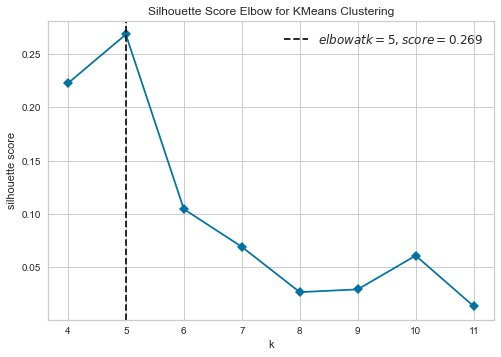

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [330]:
london_grouped_clustering = london_grouped.drop('neighborhood', 1)

# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(4,12), metric='silhouette', timings=False, locate_elbow=True)

visualizer.fit(london_grouped_clustering)# Fit the data to the visualizer
visualizer.poof() # Finalize and render the figure

Run *k*-means to cluster the neighborhood into 5 clusters since there are officially 5 main areas in London.

In [331]:
# set number of clusters
kclusters = visualizer.elbow_value_

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [332]:
# add clustering labels
neighborhoods_venues_sorted.insert(1, 'cluster_labels', kmeans.labels_)

london_merged = london_data.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.iloc[:, 3:].join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood', how='inner')

print(london_merged.shape)
london_merged.head() # check the last columns!

(92, 14)


,neighborhood,latitude,longitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Belsize Park,51.545049,-0.165131,0,Café,Pub,Hotel Bar,Italian Restaurant,Hotel,Fish & Chips Shop,Brazilian Restaurant,Breakfast Spot,Convenience Store,Market
1,Bloomsbury,51.523126,-0.126066,0,Coffee Shop,Café,Hotel,Bookstore,Pub,Exhibit,Italian Restaurant,Plaza,History Museum,Park
2,Camden Town,51.544548,-0.133398,1,Pub,Café,Garden Center,Park,Italian Restaurant,Caribbean Restaurant,Coffee Shop,Beer Bar,Bed & Breakfast,Pet Store
3,Chalk Farm,51.543969,-0.153628,0,Café,Pub,Bar,Coffee Shop,Italian Restaurant,Pizza Place,Clothing Store,French Restaurant,Music Venue,Bakery
4,Fitzrovia,51.518533,-0.137347,0,Coffee Shop,French Restaurant,Hotel,Clothing Store,Pizza Place,Cocktail Bar,Japanese Restaurant,Café,Italian Restaurant,Cycle Studio


In [333]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
color_range = list(range(0, kclusters))
colors_array = [cm.tab10(x) for x in color_range]
cat_colors = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['latitude'], london_merged['longitude'], london_merged['neighborhood'], london_merged['cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cat_colors[cluster],
        fill=True,
        fill_color=cat_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [334]:
london_merged.loc[london_merged['cluster_labels'] == 0, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Belsize Park,Café,Pub,Hotel Bar,Italian Restaurant,Hotel,Fish & Chips Shop,Brazilian Restaurant,Breakfast Spot,Convenience Store,Market
1,Bloomsbury,Coffee Shop,Café,Hotel,Bookstore,Pub,Exhibit,Italian Restaurant,Plaza,History Museum,Park
3,Chalk Farm,Café,Pub,Bar,Coffee Shop,Italian Restaurant,Pizza Place,Clothing Store,French Restaurant,Music Venue,Bakery
4,Fitzrovia,Coffee Shop,French Restaurant,Hotel,Clothing Store,Pizza Place,Cocktail Bar,Japanese Restaurant,Café,Italian Restaurant,Cycle Studio
5,Frognal,Pub,Café,Bakery,Grocery Store,BBQ Joint,Bagel Shop,Restaurant,Burger Joint,Community Center,Falafel Restaurant
6,Gospel Oak,Gym / Fitness Center,Italian Restaurant,Pizza Place,Beer Store,Farm,Cocktail Bar,Coffee Shop,French Restaurant,Bar,Train Station
7,Hampstead,Café,Pub,Bakery,Italian Restaurant,Ice Cream Shop,French Restaurant,Bistro,Bookstore,Thai Restaurant,Gym / Fitness Center
9,Holborn,Pub,Sandwich Place,Café,Bookstore,Hotel,Coffee Shop,Chinese Restaurant,Korean Restaurant,Restaurant,Japanese Restaurant
10,Kentish Town,Café,Pub,Coffee Shop,Market,Pizza Place,Ice Cream Shop,Flea Market,Recreation Center,Speakeasy,Bike Shop
11,King's Cross,Hotel,Coffee Shop,Café,Burger Joint,Pizza Place,Train Station,Bar,Breakfast Spot,Art Gallery,Pub


#### Cluster 2

In [335]:
london_merged.loc[london_merged['cluster_labels'] == 1, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Camden Town,Pub,Café,Garden Center,Park,Italian Restaurant,Caribbean Restaurant,Coffee Shop,Beer Bar,Bed & Breakfast,Pet Store
8,Highgate,Pub,Café,Trail,Bus Stop,Playground,Theater,Chinese Restaurant,Indian Restaurant,Forest,Antique Shop
23,Brompton,Pub,Café,Pizza Place,Hotel,Garden,Grocery Store,Bar,Gastropub,Speakeasy,Farmers Market
24,Chelsea,Pub,Garden,Grocery Store,French Restaurant,Harbor / Marina,Pizza Place,Café,Outdoor Sculpture,Monument / Landmark,Gym / Fitness Center
31,West Brompton,Pub,Grocery Store,Pizza Place,Farmers Market,Italian Restaurant,Vegetarian / Vegan Restaurant,Gastropub,Bistro,Gym,Gym / Fitness Center
39,Finsbury,Pub,Coffee Shop,Café,Bar,Sandwich Place,Hotel,Park,Pizza Place,Vietnamese Restaurant,Bakery
53,Stockwell,Pub,Caribbean Restaurant,Coffee Shop,Cocktail Bar,Café,Street Art,Bakery,Gym / Fitness Center,Supermarket,Brewery
55,Tulse Hill,Garden,Playground,Grocery Store,Hotel,Zoo Exhibit,Flower Shop,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market
57,West Norwood,Brewery,Sporting Goods Shop,Pub,Park,Café,Food & Drink Shop,Film Studio,Fish & Chips Shop,Fish Market,Flea Market
61,Denmark Hill,Pub,Café,Coffee Shop,Train Station,Convenience Store,Chinese Restaurant,Grocery Store,Park,Vietnamese Restaurant,Bar


#### Cluster 3

In [336]:
london_merged.loc[london_merged['cluster_labels'] == 2, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Dulwich,Forest,Zoo Exhibit,Food & Drink Shop,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food


#### Cluster 4

In [337]:
london_merged.loc[london_merged['cluster_labels'] == 3, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
71,Sydenham Hill,Forest,Pub,Park,Zoo Exhibit,Food,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market


#### Cluster 5

In [338]:
london_merged.loc[london_merged['cluster_labels'] == 4, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,Streatham,Jazz Club,Tea Room,Bar,Zoo Exhibit,Food,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market


## Comparison

#### 10 Most common venues in NYC (Manhattan)

Text(0, 0.5, 'Number of Venues')

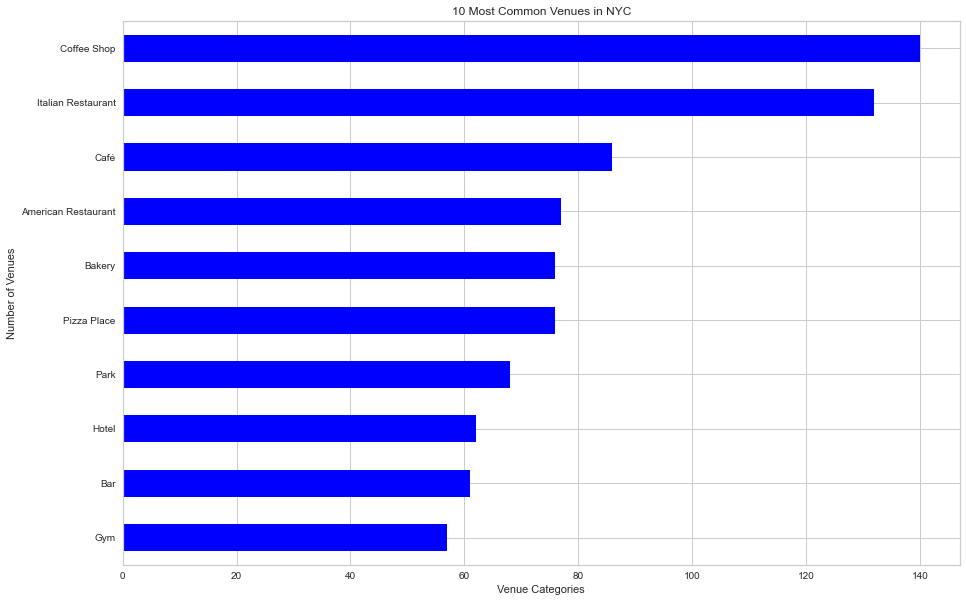

In [339]:
nyc_venues['venue_category'].value_counts(normalize=False).head(10).sort_values(ascending=True).plot(kind='barh', color='blue', figsize=(15, 10))
plt.title("10 Most Common Venues in NYC")
plt.xlabel("Venue Categories")
plt.ylabel("Number of Venues")

#### 10 Most Common Venues in London (Central)

Text(0, 0.5, 'Number of Venues')

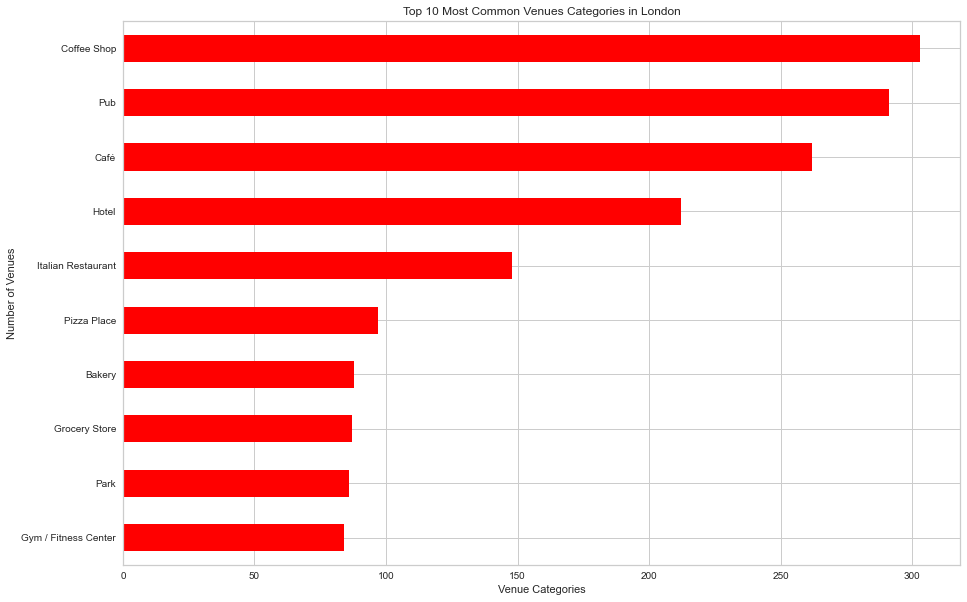

In [340]:
london_venues['venue_category'].value_counts(normalize=False).head(10).sort_values(ascending=True).plot(kind='barh', color='red', figsize=(15, 10))
plt.title("Top 10 Most Common Venues Categories in London")
plt.xlabel("Venue Categories")
plt.ylabel("Number of Venues")

### Join the NYC and London dataframes to apply *K*means

Insert column 'city' to the dataframes

In [341]:
nyc_grouped.insert(0, 'city', 'NYC')
london_grouped.insert(0, 'city', 'London')

In [342]:
df_grouped_joined = pd.concat([nyc_grouped, london_grouped], ignore_index=True).fillna(0)

print(df_grouped_joined.shape)
df_grouped_joined.head()

(132, 416)


,city,neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South Americ

Get the Top 10 venues per neighbohood

In [343]:
neighborhoods_venues_sorted = top_venues_neighboorhood(num_venues=10, city_grouped=df_grouped_joined.iloc[:, 1:])
neighborhoods_venues_sorted.insert(0, 'city', df_grouped_joined['city'])

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(132, 12)


,city,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,NYC,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Pizza Place,Playground,Plaza,Burger Joint,Clothing Store
1,NYC,Carnegie Hill,Coffee Shop,Café,Bookstore,Wine Shop,French Restaurant,Pizza Place,Italian Restaurant,Gym / Fitness Center,Gym,Yoga Studio
2,NYC,Central Harlem,African Restaurant,Seafood Restaurant,American Restaurant,Cosmetics Shop,French Restaurant,Bar,Chinese Restaurant,Public Art,Gym / Fitness Center,Bookstore
3,NYC,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Bakery,Italian Restaurant,Ice Cream Shop,Market,Cycle Studio,Bookstore,Japanese Restaurant
4,NYC,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,Hotpot Restaurant,Dessert Shop,American Restaurant,Optical Shop,Salon / Barbershop,Spa,Noodle House


### Cluster Neighborhoods 

Run Elbow method to get optimal K

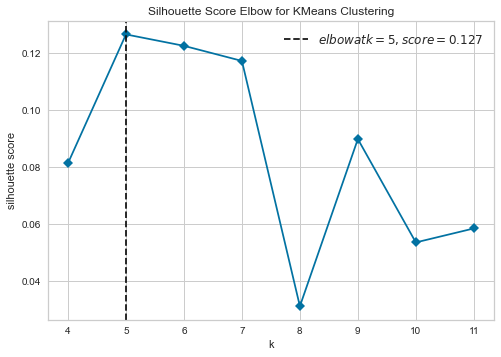

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [344]:
x = df_grouped_joined.drop(columns=['city', 'neighborhood'])

# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(4,12), metric='silhouette', timings=False, locate_elbow=True)

visualizer.fit(joined_clustering)# Fit the data to the visualizer
visualizer.poof() # Finalize and render the figure

In [347]:
# set number of clusters
kclusters = visualizer.elbow_value_

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(joined_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [348]:
# add clustering labels
df_grouped_joined.insert(2, 'cluster_labels', kmeans.labels_)
neighborhoods_venues_sorted.insert(2, 'cluster_labels', kmeans.labels_)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(132, 13)


,city,neighborhood,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,NYC,Battery Park City,0,Park,Hotel,Gym,Coffee Shop,Memorial Site,Pizza Place,Playground,Plaza,Burger Joint,Clothing Store
1,NYC,Carnegie Hill,0,Coffee Shop,Café,Bookstore,Wine Shop,French Restaurant,Pizza Place,Italian Restaurant,Gym / Fitness Center,Gym,Yoga Studio
2,NYC,Central Harlem,0,African Restaurant,Seafood Restaurant,American Restaurant,Cosmetics Shop,French Restaurant,Bar,Chinese Restaurant,Public Art,Gym / Fitness Center,Bookstore
3,NYC,Chelsea,0,Coffee Shop,Art Gallery,American Restaurant,Bakery,Italian Restaurant,Ice Cream Shop,Market,Cycle Studio,Bookstore,Japanese Restaurant
4,NYC,Chinatown,0,Chinese Restaurant,Cocktail Bar,Bakery,Hotpot Restaurant,Dessert Shop,American Restaurant,Optical Shop,Salon / Barbershop,Spa,Noodle House


In [350]:
joined_cluster1 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster_labels'] == 0, neighborhoods_venues_sorted.columns[[0, 1] + list(range(3, neighborhoods_venues_sorted.shape[1]))]]

print(joined_cluster1.shape)
joined_cluster1.head()

(83, 12)


,city,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,NYC,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Pizza Place,Playground,Plaza,Burger Joint,Clothing Store
1,NYC,Carnegie Hill,Coffee Shop,Café,Bookstore,Wine Shop,French Restaurant,Pizza Place,Italian Restaurant,Gym / Fitness Center,Gym,Yoga Studio
2,NYC,Central Harlem,African Restaurant,Seafood Restaurant,American Restaurant,Cosmetics Shop,French Restaurant,Bar,Chinese Restaurant,Public Art,Gym / Fitness Center,Bookstore
3,NYC,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Bakery,Italian Restaurant,Ice Cream Shop,Market,Cycle Studio,Bookstore,Japanese Restaurant
4,NYC,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,Hotpot Restaurant,Dessert Shop,American Restaurant,Optical Shop,Salon / Barbershop,Spa,Noodle House


In [119]:
# Compute Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity

nyc_london_cluster1 = df_grouped_joined.copy()
nyc_london_cluster1 = nyc_london_cluster1.loc[neighborhoods_venues_sorted['cluster_labels'] == 0]

# cluster1_similarity = nyc_london_cluster1.iloc[:, :2]
# cluster1_similarity
nyc_london_cluster1.head()

,city,neighborhood,cluster_labels,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit

In [167]:
nyc_london_cluster1.iloc[0, 3:].reshape(1, -1)
# print(kmeans.cluster_centers_[0][:3])

AttributeError: 'Series' object has no attribute 'reshape'

In [158]:
# kmeans.cluster_centers_[0].reshape(-1, 1)

In [172]:
cosine_similarity(nyc_london_cluster1.iloc[0, 3:].values.reshape(1, -1), kmeans.cluster_centers_[0].reshape(1, -1))

array([[0.48840138]])

In [173]:
def similarity_from_centroid(row, centroid):
    return cosine_similarity(np.array(row.iloc[3:]).reshape(1, -1), centroid.reshape(1, -1))

In [197]:
index = nyc_london_cluster1.apply(similarity_from_centroid, centroid=kmeans.cluster_centers_[0], axis=1).sort_values(ascending=False).index

In [201]:
df_grouped_joined.iloc[index, :2].groupby('city').count()

,neighborhood
city,
London,284
NYC,33


* Compare the neighboorhoods that are more similar to each other between NYC and London
* Compare the official borough classification with kmeans classification 

Cluster 2

In [359]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster_labels'] == 1, neighborhoods_venues_sorted.columns[[0, 1] + list(range(3, neighborhoods_venues_sorted.shape[1]))]].iloc[:, :2].groupby('city').count()

,neighborhood
city,
London,1


In [351]:
joined_cluster2 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster_labels'] == 1, neighborhoods_venues_sorted.columns[[0, 1] + list(range(3, neighborhoods_venues_sorted.shape[1]))]]

print(joined_cluster2.shape)
joined_cluster2.head()

(1, 12)


,city,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
118,London,Streatham,Bar,Jazz Club,Tea Room,Zoo Exhibit,Health Food Store,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym


#### Cluster 3

In [353]:
joined_cluster3 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster_labels'] == 2, neighborhoods_venues_sorted.columns[[0, 1] + list(range(3, neighborhoods_venues_sorted.shape[1]))]]

print(joined_cluster3.shape)
joined_cluster3.head()

(46, 12)


,city,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,London,Angel,Pub,Coffee Shop,Café,Arts & Crafts Store,Mediterranean Restaurant,Gym / Fitness Center,Vietnamese Restaurant,Hotel,Mexican Restaurant,French Restaurant
43,London,Archway,Coffee Shop,Grocery Store,Pub,Pizza Place,Italian Restaurant,Café,Vegetarian / Vegan Restaurant,Kebab Restaurant,Japanese Restaurant,Indian Restaurant
46,London,Barnsbury,Coffee Shop,Café,Park,Brewery,Grocery Store,Breakfast Spot,Greek Restaurant,Pub,Rental Car Location,Soccer Field
47,London,Bayswater,Pub,Coffee Shop,Café,Greek Restaurant,Chinese Restaurant,Italian Restaurant,Yoga Studio,Pizza Place,Grocery Store,Burger Joint
49,London,Belsize Park,Café,Pub,Italian Restaurant,Hotel,Hotel Bar,Bus Stop,Brazilian Restaurant,Grocery Store,Breakfast Spot,Deli / Bodega


#### Cluster 4

In [358]:
joined_cluster4 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster_labels'] == 3, neighborhoods_venues_sorted.columns[[0, 1] + list(range(3, neighborhoods_venues_sorted.shape[1]))]]

print(joined_cluster4.shape)
joined_cluster4.head()

(1, 12)


,city,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
66,London,Dulwich,Forest,Zoo Exhibit,Health Food Store,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina


#### Cluster 5

In [357]:
joined_cluster5 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster_labels'] == 4, neighborhoods_venues_sorted.columns[[0, 1] + list(range(3, neighborhoods_venues_sorted.shape[1]))]]

print(joined_cluster5.shape)
joined_cluster5.head()

(1, 12)


,city,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
121,London,Sydenham Hill,Forest,Park,Pub,Heliport,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina


* London has far more neighborhoods so there are always more london neighborhoods in each cluster
* 

Let's use the PCA algorithm to minimize each neighborhood dimensions so we can plot a graph in 2 dimensions to easily compare them.

In [103]:
nyc_grouped.head()

,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North 

In [105]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principal_components = pca.fit_transform(nyc_grouped.iloc[:, 1:])

df_nyc_pca = pd.DataFrame(data=principal_components, columns=['pc1', 'pc2'])
df_nyc_pca.insert(0, 'neighborhood', nyc_grouped['neighborhood'])

df_nyc_pca.head()

,neighborhood,pc1,pc2
0,Allerton,-0.040814,-0.030186
1,Annadale,0.045538,-0.019597
2,Arden Heights,-0.071282,-0.004170
3,Arlington,-0.033144,0.032716
4,Arrochar,-0.036126,0.062299
